In [0]:
%reset -f

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
# https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import tensorflow as tf
import time

print(tf.__version__)

1.13.1


In [0]:
import os
import numpy as np
npzfile=np.load('/content/gdrive/My Drive/python-cloud/rawtrainfile.npz')
npzfile.files

images=npzfile['arr_0']
labels=npzfile['arr_1']




In [5]:
npimages=np.array(images)
nplabels=np.array(labels)
print('images shape: {} \n labels shape: {}'.format(npimages.shape, nplabels.shape))
print('first image shape: {} \n first eleven label shape: {}'.format(npimages[0].shape, nplabels[0:10]))


images shape: (39209,) 
 labels shape: (39209,)
first image shape: (30, 29, 3) 
 first eleven label shape: [0 0 0 0 0 0 0 0 0 0]


In [6]:
from skimage.transform import resize

images48 = [resize(image, (48, 48)) for image in npimages]
print(type(images48))


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<class 'list'>


In [7]:
images48 = np.array(images48)
print('total number of images and size {}'.format(images48.shape))
print(images48[0].shape)

total number of images and size (39209, 48, 48, 3)
(48, 48, 3)


In [8]:
import keras
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling2D, CuDNNGRU, CuDNNLSTM, Reshape
from keras.layers import Dropout, Dense, Activation, Flatten,Conv2D,  BatchNormalization
from keras.models import Sequential
from keras.layers import LSTM  


model = Sequential()
model.add(Conv2D(1, kernel_size=(1, 1),padding='valid', strides=1, activation='relu', input_shape=(48,48,3)))
model.add(BatchNormalization())
model.add(Conv2D(29, 5, padding='valid', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3,  padding='valid',strides=2))
model.add(Dropout(0.1))
                 
model.add(Conv2D(59, 3,  padding='valid',strides=1, activation='relu')) # increase kernel size to 5
model.add(BatchNormalization())
model.add(MaxPooling2D(3,strides=2,  padding='valid'))
model.add(Dropout(0.1))

model.add(Conv2D(74, 3, strides=1, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(3,strides=2,  padding='valid'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(300))
model.add(Dropout(0.5))
model.add(Dense(225))
model.add(Dropout(0.5))
model.add(Reshape((15, 15)))
#model.add(LSTM(86, dropout=0.1, recurrent_dropout=0.5)) # defaults inclide tanh activation
model.add(CuDNNLSTM(86))
model.add(Dense(43, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 1)         4         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 29)        754       
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 29)        116       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 29)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 29)        0         
___________________________

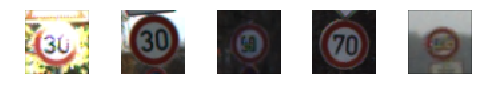

In [9]:
## Training plot

import matplotlib.pyplot as plt

traffic_signs = [250, 2120, 3400, 6500,9000]

for i in range(len(traffic_signs)):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    #plt.imshow(images27[traffic_signs[i]], cmap="gray")
    plt.imshow(images48[traffic_signs[i]])
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

In [10]:

X_train=images48.astype('float32')

print(X_train.shape)

#nplabels=np.array(labels)
print("First label is %s and Total labels shape are %s" %(nplabels[0], nplabels.shape))


Y = keras.utils.to_categorical(nplabels,43)

print("after one hot coding Labels shape is:",Y.shape)
print("First Label after one hot coding:",Y[0])

(39209, 48, 48, 3)
First label is 0 and Total labels shape are (39209,)
after one hot coding Labels shape is: (39209, 43)
First Label after one hot coding: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
import pandas as pd
import os
import numpy as np
npzfilet=np.load('/content/gdrive/My Drive/python-cloud/rawtestfile.npz')
npzfilet.files

X_test=npzfilet['arr_0']
y_test=npzfilet['arr_1']



test_images = np.array(X_test)
test_labels = np.array(y_test)


In [12]:
test_images.shape

(12630,)

In [13]:
from skimage import transform
from skimage.color import rgb2gray

test_imagesnp=np.array(test_images)
    

# Transform the images to 28 by 28 pixels
test_images48 = [transform.resize(image, (48, 48)) for image in test_imagesnp]



/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


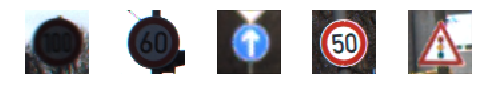

In [14]:
import matplotlib.pyplot as plt

testsigns = [150, 700, 1100, 1500,5000]

for i in range(len(testsigns)):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    #plt.imshow(images27[traffic_signs[i]], cmap="gray")
    plt.imshow(test_images48[testsigns[i]])
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

In [15]:
tnpimages=np.array(test_images48)
tnplabels=np.array(test_labels)
print('images shape: {} \n labels shape: {}'.format(tnpimages.shape, tnplabels.shape))
print('first image shape: {} \n first eleven label shape: {}'.format(tnpimages[0].shape, tnplabels[0:10]))


images shape: (12630, 48, 48, 3) 
 labels shape: (12630,)
first image shape: (48, 48, 3) 
 first eleven label shape: [16  1 38 33 11 38 18 12 25 35]


In [0]:
#X_test=test_images27
X_test=tnpimages.astype('float32')

Y_test = keras.utils.to_categorical(tnplabels,43)


In [17]:

start_time = time.time()
print('Start time in seconds is : {}'.format(start_time))

Start time in seconds is : 1552360655.0935597


In [18]:


model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy']) 

epoch=150
history=model.fit(X_train, Y, validation_data=(X_test, Y_test),epochs=epoch, batch_size=128, shuffle=True, verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 39209 samples, validate on 12630 samples
Epoch 1/150
39209/39209 [==============================] - 19s 479us/step - loss: 3.1603 - acc: 0.1274 - val_loss: 2.6890 - val_acc: 0.2185
Epoch 2/150
39209/39209 [==============================] - 14s 368us/step - loss: 1.9131 - acc: 0.4158 - val_loss: 1.7449 - val_acc: 0.4617
Epoch 3/150
39209/39209 [==============================] - 14s 368us/step - loss: 1.1882 - acc: 0.6188 - val_loss: 1.1145 - val_acc: 0.6634
Epoch 4/150
39209/39209 [==============================] - 14s 368us/step - loss: 0.7984 - acc: 0.7465 - val_loss: 0.7127 - val_acc: 0.7830
Epoch 5/150
39209/39209 [==============================] - 14s 370us/step - loss: 0.5385 - acc: 0.8308 - val_loss: 0.4830 - val_acc: 0.8501
Epoch 6/150
39209/39209 [==============================] - 14s 367us/step - loss: 0.3719 - acc: 0.8881 - val_loss: 0.3593 - val_acc: 0.9027
Epoch 7/150
39209/39209 [==============================] - 14s

In [19]:
print("Total time to run %s seconds" % (time.time() - start_time))


Total time to run 2168.7057995796204 seconds


In [20]:

print('final learning rate',keras.backend.eval(model.optimizer.lr))

v=history.history['val_acc']
test_accuracy=v[-10 :]
print('test accuracy average for 10 epochs is :', sum(test_accuracy) / len(test_accuracy))


final learning rate 1.0
test accuracy average for 10 epochs is : 0.9864133016589325


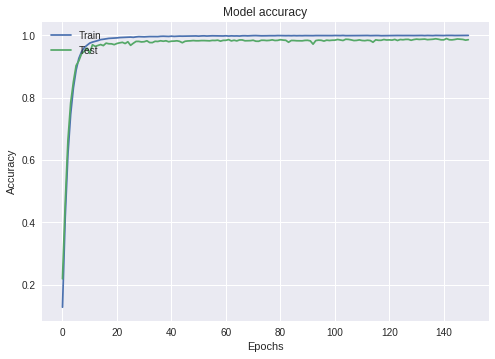

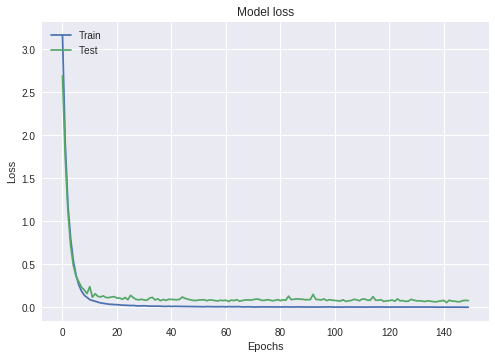

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# y_prob = model.predict(tnpimages)
# y_prob[1]

In [23]:
ypred=model.predict_classes(tnpimages)
tnplabels[10]

12

In [24]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(tnplabels, ypred)
print(cm)

[[ 60   0   0 ...   0   0   0]
 [  0 719   1 ...   0   0   0]
 [  0   1 748 ...   0   0   0]
 ...
 [  0   1   0 ...  83   0   0]
 [  0   0   0 ...   0  56   0]
 [  0   0   0 ...   0   0  90]]


In [25]:
from sklearn.metrics import classification_report
print(classification_report(tnplabels, ypred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       0.99      0.97      0.98       450
           4       1.00      0.99      0.99       660
           5       0.97      0.99      0.98       630
           6       0.99      0.99      0.99       150
           7       0.99      1.00      1.00       450
           8       1.00      0.98      0.99       450
           9       0.99      1.00      0.99       480
          10       0.99      1.00      1.00       660
          11       0.99      1.00      1.00       420
          12       0.99      1.00      0.99       690
          13       0.99      0.99      0.99       720
          14       1.00      0.99      0.99       270
          15       0.99      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       0.99    

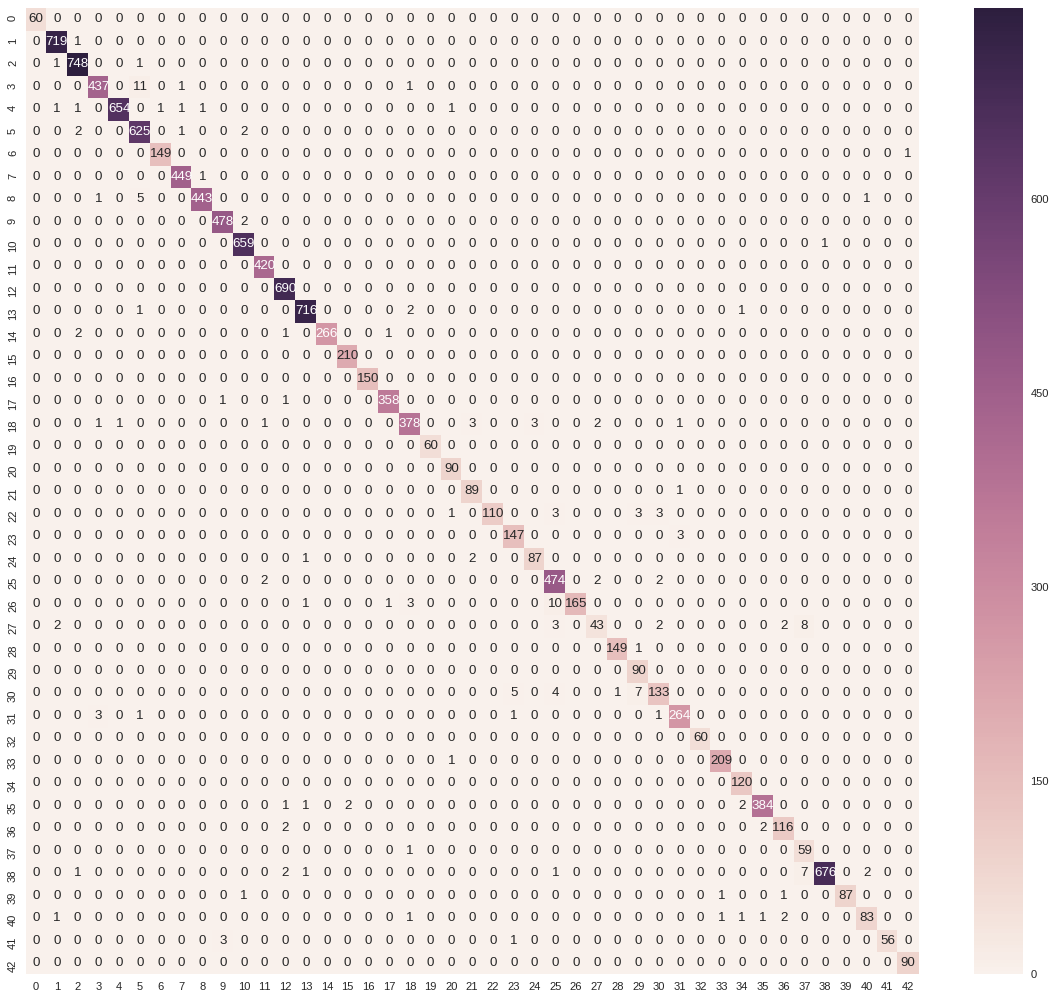

In [26]:
import seaborn as sns
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')


sns.heatmap(confusion_matrix(tnplabels, ypred),annot=True,fmt="d") 


In [0]:
data1=tnpimages


98.57482185273159
87.75138558514611
78.38479811297648
72.01900239511794
67.07046716154707
62.66033255666943
59.41409344722237
56.88044340008322
54.02216943029553
51.25098971223794
49.69121140142518
47.12589073020696
45.756136192656285
43.65003958592222
42.201108463397595
40.27711797213611
39.493269992554275
37.838479817999044
36.97545526948885
35.75613617897034


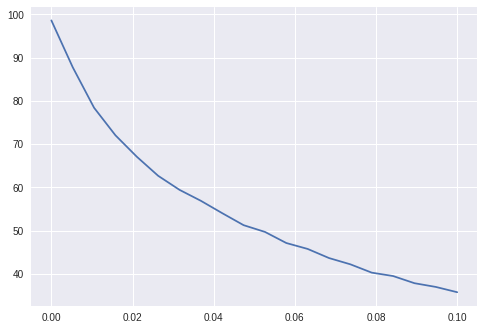

In [28]:
## gaussian noise evaluation

from skimage.util import random_noise
from skimage import transform
import matplotlib.pyplot as plt

import numpy as np
vara=np.linspace(0, 0.1, 20)
i=0
b=np.zeros((len(vara),1))
for a in vara:

  gaussian_noise_imgs = [random_noise(image, mode='gaussian',mean=0,var=a,seed=None, clip=True) for image in data1]
  gaussian_noise_imgs=np.array(gaussian_noise_imgs)
  
  gaussian_noise_imgs=gaussian_noise_imgs.astype('float32')
  score = model.evaluate(gaussian_noise_imgs, Y_test, batch_size=128, verbose=0)
  b[i]=score[1]*100
  i+=1

  print(score[1]*100)
  
 
fig, ax = plt.subplots()
ax.plot(vara, b)

  
 

In [0]:

data2=tnpimages

In [30]:

sd1=[10, 10,10]
sd2=[20, 20,20]
sd3=[30, 30,30]
sd4=[40, 40,40]
sd5=[50, 50,50]
sd6=[6.3, 6.3, 6.3]
sd7=[12.75, 12.75, 12.75]
sd8=[19.21, 19.21, 19.21]
sdrange=[sd1,sd2,sd3,sd4,sd5,sd6,sd7,sd8]


nprn=np.zeros(3)

for sd in sdrange:
  i=0
  for values in sd:
      nsd=values/255
      varsd=nsd*nsd
      gaussian_noise_imgs = [random_noise(image, mode='gaussian',mean=0,var=varsd,seed=None, clip=True) for image in data2]
      gaussian_noise_imgs=np.array(gaussian_noise_imgs)
      
      gaussian_noise_imgs=gaussian_noise_imgs.astype('float32')
      score = model.evaluate(gaussian_noise_imgs, Y_test, batch_size=128, verbose=0)
      print('Accuracy is:', score[1], 'for sd', values)  
      nprn[i]=score[1]
      i+=1

      

  avgsd=nprn
  print(' accuracy average is :', sum(avgsd) / len(avgsd))


Accuracy is: 0.9637371337706384 for sd 10
Accuracy is: 0.9626286618405642 for sd 10
Accuracy is: 0.9612034836932958 for sd 10
 accuracy average is : 0.9625230931014994
Accuracy is: 0.857482185188212 for sd 20
Accuracy is: 0.855344418222151 for sd 20
Accuracy is: 0.8571654788955091 for sd 20
 accuracy average is : 0.8566640274352907
Accuracy is: 0.7397466350809884 for sd 30
Accuracy is: 0.7379255740489643 for sd 30
Accuracy is: 0.7440221694944779 for sd 30
 accuracy average is : 0.7405647928748101
Accuracy is: 0.6425969911489993 for sd 40
Accuracy is: 0.6391923990215654 for sd 40
Accuracy is: 0.6435471102441952 for sd 40
 accuracy average is : 0.6417788334715866
Accuracy is: 0.5575613619501593 for sd 50
Accuracy is: 0.5583531276630392 for sd 50
Accuracy is: 0.5580364212948278 for sd 50
 accuracy average is : 0.5579836369693422
Accuracy is: 0.9795724465558194 for sd 6.3
Accuracy is: 0.9791765637371338 for sd 6.3
Accuracy is: 0.9790973871733967 for sd 6.3
 accuracy average is : 0.97928213

psnr of original image and true image : 14.09373946196701
float64
float64


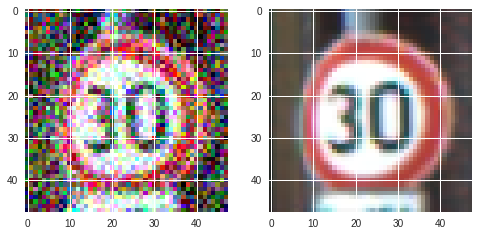

In [31]:
  #psnr calculatioon
  
  import skimage
  import numpy as np
  from skimage import img_as_float
  b=1
  
  a = random_noise(tnpimages[b], mode='gaussian',mean=0,var=0.05,seed=None, clip=True) 
  plt.subplot(1, 2,1)
  plt.imshow(a)
  plt.subplot(1, 2,2)
  c=tnpimages[b]
  plt.imshow(c)
  imtrue=img_as_float	(c)
  imtest=a
  print('psnr of original image and true image :',skimage.measure.compare_psnr(imtrue, imtest, data_range=None))
  
  print(imtrue.dtype)
  print(imtest.dtype)

In [0]:

model.save('/content/gdrive/My Drive/python-cloud/New/keras4_CUlstm_adadelta_pooldrop.h5')